<a href="https://colab.research.google.com/github/mrsambaga/IOT-Capstone-Project/blob/main/BMP388%20Compensator/Time_Series_Forecasting_with_VAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd

In [43]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [20]:
col_names=['Date Time', 'Height (m)', 'Pressure (hpa)', 'Temperature ( *C )']
csv1 = pd.read_csv (r'388_2.csv')
csv2 = pd.read_csv (r'bmp1_bawah.csv', names=col_names, header=None)
csv3 = pd.read_csv (r'bmp388_atas_pengukuran2.csv', names=col_names, header=None)
csv4 = pd.read_csv (r'bmp3882_pengukuran3.csv', names=col_names, header=None)

In [21]:
csv1.head()

,Date Time,Height (m),Pressure (hpa),Temperature ( *C )
0,[2022-05-25 01:43:51.345],57.35,1006.38,30.76
1,[2022-05-25 01:53:51.333],57.25,1006.39,30.74
2,[2022-05-25 02:03:51.341],56.77,1006.45,30.67
3,[2022-05-25 02:13:51.349],56.26,1006.51,30.60
4,[2022-05-25 02:23:51.327],55.53,1006.60,30.56


In [22]:
csv2.head()

,Date Time,Height (m),Pressure (hpa),Temperature ( *C )
0,[2022-05-27 00:08:43.414],54.15,1006.76,28.95
1,[2022-05-27 00:18:43.391],54.44,1006.73,29.00
2,[2022-05-27 00:28:43.368],54.75,1006.69,29.00
3,[2022-05-27 00:38:43.345],55.09,1006.65,28.99
4,[2022-05-27 00:48:43.337],55.57,1006.59,28.95


In [23]:
csv3.head()

,Date Time,Height (m),Pressure (hpa),Temperature ( *C )
0,[2022-05-31 22:22:16.732],62.28,1005.79,28.20
1,[2022-05-31 22:32:16.726],62.15,1005.81,28.17
2,[2022-05-31 22:42:16.723],61.91,1005.84,28.22
3,[2022-05-31 22:52:16.720],61.40,1005.90,28.32
4,[2022-05-31 23:02:16.717],61.31,1005.91,28.39


In [24]:
csv4.head()

,Date Time,Height (m),Pressure (hpa),Temperature ( *C )
0,[2022-06-01 21:56:33.874],60.81,1005.97,29.80
1,[2022-06-01 22:06:33.867],61.05,1005.94,29.85
2,[2022-06-01 22:16:33.859],61.14,1005.93,29.92
3,[2022-06-01 22:26:33.852],61.17,1005.92,29.98
4,[2022-06-01 22:36:33.860],61.05,1005.94,30.03


In [25]:
dataframes = [csv1, csv2, csv3, csv4]

In [26]:
idx = 1
for data in dataframes:
  name = "csv"+ str(idx)
  print(f'{name} has ' + str(len(data.index)) + ' rows')
  idx += 1

csv1 has 59 rows
csv2 has 43 rows
csv3 has 107 rows
csv4 has 117 rows


In [50]:
bmp388_combined = pd.concat(dataframes, ignore_index=True)

In [51]:
bmp388_combined.head()

,Date Time,Height (m),Pressure (hpa),Temperature ( *C )
0,[2022-05-25 01:43:51.345],57.35,1006.38,30.76
1,[2022-05-25 01:53:51.333],57.25,1006.39,30.74
2,[2022-05-25 02:03:51.341],56.77,1006.45,30.67
3,[2022-05-25 02:13:51.349],56.26,1006.51,30.60
4,[2022-05-25 02:23:51.327],55.53,1006.60,30.56


In [52]:
print('bmp388_combined has ' + str(len(bmp388_combined.index)) + ' rows')

bmp388_combined has 326 rows


In [53]:
bmp388_combined['Date Time'] = bmp388_combined['Date Time'].str[1:-6]
bmp388_combined['Date Time'] = pd.to_datetime(bmp388_combined['Date Time'], format='%Y/%m/%d %H:%M:%S')

In [47]:
bmp388_combined = bmp388_combined.set_index('Date Time')

In [54]:
bmp388_combined.head()

,Date Time,Height (m),Pressure (hpa),Temperature ( *C )
0,2022-05-25 01:43:51,57.35,1006.38,30.76
1,2022-05-25 01:53:51,57.25,1006.39,30.74
2,2022-05-25 02:03:51,56.77,1006.45,30.67
3,2022-05-25 02:13:51,56.26,1006.51,30.60
4,2022-05-25 02:23:51,55.53,1006.60,30.56


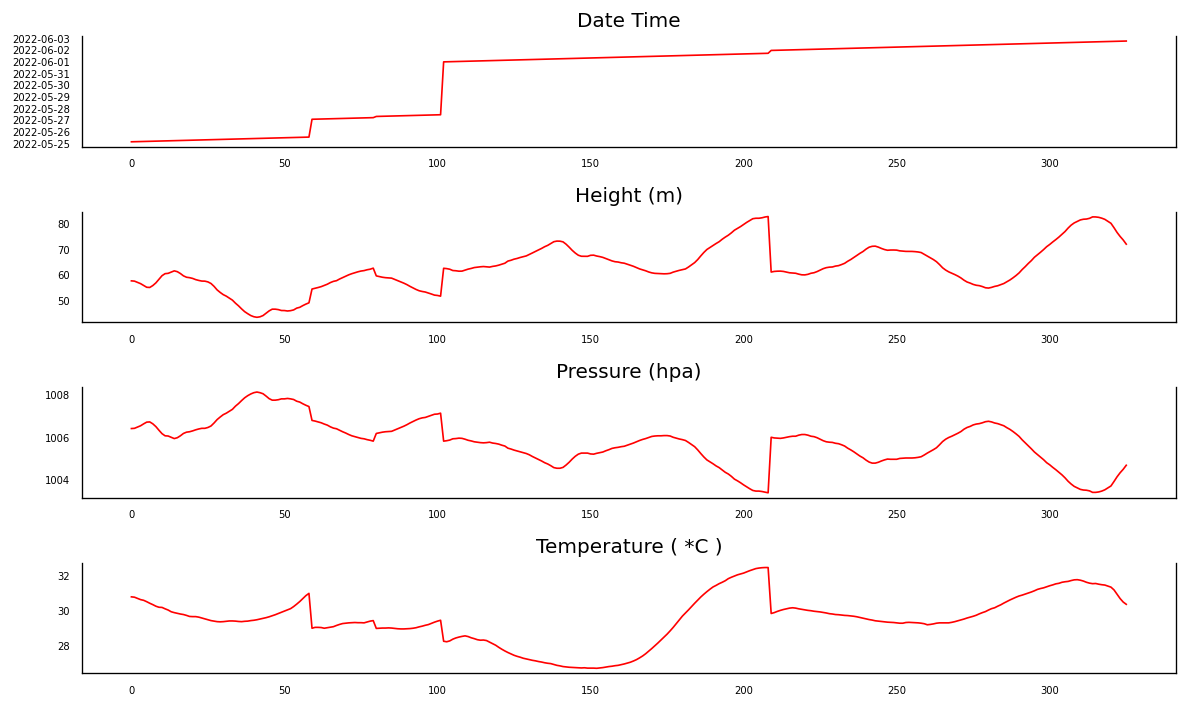

In [55]:
fig, axes = plt.subplots(nrows=4, ncols=1, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = bmp388_combined[bmp388_combined.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(bmp388_combined.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [59]:
ad_fuller_result_1 = adfuller(bmp388_combined['Height (m)'].diff()[1:])

print('Height')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(bmp388_combined['Pressure (hpa)'].diff()[1:])

print('Pressure')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

print('\n---------------------\n')

ad_fuller_result_3 = adfuller(bmp388_combined['Temperature ( *C )'].diff()[1:])

print('Temperature')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

Height
ADF Statistic: -8.244870580825486
p-value: 5.589090323987414e-13

---------------------

Pressure
ADF Statistic: -10.407302180371
p-value: 1.842524336733378e-18

---------------------

Temperature
ADF Statistic: -10.407302180371
p-value: 1.842524336733378e-18


In [60]:
print('Height causes Pressure?\n')
print('------------------')
granger_1 = grangercausalitytests(bmp388_combined[['Height (m)', 'Pressure (hpa)']], 4)

print('\Pressure causes Height?\n')
print('------------------')
granger_2 = grangercausalitytests(bmp388_combined[['Pressure (hpa)', 'Height (m)']], 4)

print('Height causes Temperature?\n')
print('------------------')
granger_1 = grangercausalitytests(bmp388_combined[['Height (m)', 'Temperature ( *C )']], 4)

print('\Temperature causes Height?\n')
print('------------------')
granger_2 = grangercausalitytests(bmp388_combined[['Temperature ( *C )', 'Height (m)']], 4)

print('Pressure causes Temperature?\n')
print('------------------')
granger_1 = grangercausalitytests(bmp388_combined[['Pressure (hpa)', 'Temperature ( *C )']], 4)

print('\Temperature causes Pressure?\n')
print('------------------')
granger_2 = grangercausalitytests(bmp388_combined[['Temperature ( *C )', 'Pressure (hpa)']], 4)

Height causes Pressure?

------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2583  , p=0.6116  , df_denom=322, df_num=1
ssr based chi2 test:   chi2=0.2607  , p=0.6096  , df=1
likelihood ratio test: chi2=0.2606  , p=0.6097  , df=1
parameter F test:         F=0.2583  , p=0.6116  , df_denom=322, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.8296  , p=0.0227  , df_denom=319, df_num=2
ssr based chi2 test:   chi2=7.7792  , p=0.0205  , df=2
likelihood ratio test: chi2=7.6873  , p=0.0214  , df=2
parameter F test:         F=3.8296  , p=0.0227  , df_denom=319, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.2613  , p=0.0813  , df_denom=316, df_num=3
ssr based chi2 test:   chi2=6.9341  , p=0.0740  , df=3
likelihood ratio test: chi2=6.8607  , p=0.0765  , df=3
parameter F test:         F=2.2613  , p=0.0813  , df_denom=316, df_num=3

Granger Causality
number of lags (no zero) 4
ssr 

In [62]:
bmp388_combined.corr()

,Height (m),Pressure (hpa),Temperature ( *C )
Height (m),1.000000,-0.999996,0.230234
Pressure (hpa),-0.999996,1.000000,-0.229958
Temperature ( *C ),0.230234,-0.229958,1.000000
